In [15]:
import sys
sys.path.append("..")
from divexp import *
from detect import *

import numpy as np
np.float = float
from skmultiflow.data import ConceptDriftStream, STAGGERGenerator, AGRAWALGenerator, LEDGenerator, SEAGenerator, RandomRBFGeneratorDrift
from skmultiflow.data import HyperplaneGenerator

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import KBinsDiscretizer
import pandas as pd

In [16]:
class Discretizable:
    def __init__(self, n_bins, **kwargs):
        self.kb = KBinsDiscretizer(encode="onehot-dense", n_bins=n_bins, strategy="uniform")
        self.kb_fit = False
        self.input_features = None
    
    def get_metadata(self, X):
        if not self.kb_fit:
            X_bin = self.kb.fit_transform(X).astype(bool)
            self.kb_fit = True
        else:
            X_bin = self.kb.transform(X).astype(bool)
        return pd.DataFrame(data=X_bin, columns=self.kb.get_feature_names_out(input_features=self.input_features))

class SEAWrapper(Discretizable):
    def __init__(self, random_state=42, noise_percentage=0.0):
        super().__init__(n_bins=5)

        function_from, function_to = np.random.choice(4, size=2, replace=False)
        
        self.stream=SEAGenerator(
            balance_classes=False,
            classification_function=function_from,
            noise_percentage=noise_percentage,
            random_state=random_state
        )

        self.drift_stream=SEAGenerator(
            balance_classes=False,
            classification_function=function_to,
            noise_percentage=noise_percentage,
            random_state=random_state
        )

class AgrawalWrapper(Discretizable):

    def __init__(self, random_state=42, perturbation=0.0):
        super().__init__(n_bins=5)

        function_from, function_to = 0, 2
        # function_from, function_to = np.random.choice(10, size=2, replace=False)

        self.stream=AGRAWALGenerator(
            balance_classes=False,
            classification_function=function_from,
            perturbation=perturbation,
            random_state=random_state
        )

        self.drift_stream=AGRAWALGenerator(
            balance_classes=False,
            classification_function=function_to,
            perturbation=perturbation,
            random_state=random_state
        )

        self.input_features = [
            "salary",
            "commission",
            "age",
            "elevel",
            "car",
            "zipcode",
            "hvalue",
            "hyears",
            "loan"
        ]

class HyperplaneWrapper(Discretizable):
    def __init__(self, random_state=42, noise_percentage=0.0):
        super().__init__(n_bins=5)

        self.stream = HyperplaneGenerator(
            random_state=random_state,
            noise_percentage=noise_percentage
        )
        
        self.drift_stream = HyperplaneGenerator(
            random_state=random_state+1,
            noise_percentage=noise_percentage
        )

# trivial -- not included
# class LEDWrapper(Discretizable):
#     def __init__(self, random_state=42, noise_percentage=0.0):
#         super().__init__(n_bins=5)
        
#         self.stream = LEDGenerator(
#             random_state=random_state,
#             noise_percentage=noise_percentage
#         )
        
#         self.drift_stream = LEDGenerator(
#             random_state=random_state+1,
#             noise_percentage=noise_percentage
#         )

# trivial -- not included
# class STAGGERWrapper(Discretizable):
#     def __init__(self, random_state=42):
#         super().__init__(n_bins=5)
        
#         function_from, function_to = np.random.choice(3, size=2, replace=False)

#         self.stream = STAGGERGenerator(
#             random_state=random_state,
#             classification_function=function_from
#         )
        
#         self.drift_stream = STAGGERGenerator(
#             random_state=random_state,
#             classification_function=function_to
#         )

In [17]:
def train_and_drift(DataSource, drift=True, ds_kwargs={}, train_size=5_000, n_batches=50, batch_size=200, ClfModel=DecisionTreeClassifier, clf_kwargs={}):
    tot_samples = n_batches * batch_size # total number of samples
    position = (n_batches // 2) * batch_size # "center" of the drift
    width = (n_batches // 4) * batch_size # size of the transitory

    subgroup_metric = "accuracy"
    overall_metric = accuracy_score
    minsup = 0.1
    win_size = 5
    reference_window = (0,win_size)
    current_window = (n_batches - win_size, n_batches)

    data_source = DataSource(**ds_kwargs)
    stream = data_source.stream
    drift_stream = data_source.drift_stream

    if drift:
        cds = ConceptDriftStream(stream=stream, drift_stream=drift_stream, position=position, width=width)
    else:
        cds = ConceptDriftStream(stream=stream, drift_stream=stream, position=position, width=width) # no drift!

    X_train, y_train = stream.next_sample(train_size)

    clf = ClfModel(**clf_kwargs)
    clf.fit(X_train, y_train)
    
    df_meta = data_source.get_metadata(X_train)
    matches = compute_matches(df_meta, minsup=minsup)
    print("# FI", len(matches.fi))

    divs = []
    matches_ts_list = []
    scores = []

    for start_ndx in range(0, tot_samples, batch_size):
        X_batch, y_batch = cds.next_sample(batch_size)
        
        y_pred = clf.predict(X_batch)

        # Workaround for multi-class problems -- works with accuracy!
        y_pred = y_batch == y_pred
        y_batch = np.ones(len(y_batch))

        scores.append(overall_metric(y_batch, y_pred))

        df_batch_bin = data_source.get_metadata(X_batch)
        matches_ts = compute_matches(df_batch_bin, fi=matches.fi)
        matches_ts = Matches(matches=matches_ts.matches.astype(int), fi=matches.fi)

        divs.append(div_explorer(matches_ts, y_batch, y_pred, [subgroup_metric]))
        matches_ts_list.append(matches_ts)

    delta, t_stat = detect_singlebatch(divs, subgroup_metric, reference_window, current_window)

    return delta.min(), t_stat.max()

In [13]:
n_exp = {
    True: 5, # number for "with drift"
    False: 5 # number for "without drift"
}
train_size = 5_000

n_batches  = 50
batch_size = 200

tstats = np.empty(sum(n_exp.values()))
deltas = np.empty(sum(n_exp.values()))
gt = np.empty(sum(n_exp.values()))

exp_type = "hyper"

if exp_type == "sea":
    DataClass = SEAWrapper
    data_kwargs = {"noise_percentage": 0.7}
elif exp_type == "agrawal":
    DataClass = AgrawalWrapper
    data_kwargs = {"perturbation": 0.7}
elif exp_type == "hyper":
    DataClass = HyperplaneWrapper
    data_kwargs = {"noise_percentage": 0.1}
# elif exp_type == "stagger":
#     DataClass = STAGGERWrapper
#     data_kwargs = {}
# elif exp_type == "led":
#     DataClass = LEDWrapper
#     data_kwargs = {"noise_percentage": 0.}
    
# elif exp_type == "rbf":
#     DataClass = RBFWrapper
#     data_kwargs = {}

i = 0
t0 = time()
for drift in n_exp:
    for exp in range(n_exp[drift]):

        delta, tstat = train_and_drift(DataClass,
                                       ds_kwargs={ "random_state": i, **data_kwargs },
                                       drift=drift,
                                       train_size=train_size,
                                       n_batches=n_batches,
                                       batch_size=batch_size,
                                       ClfModel=DecisionTreeClassifier,
                                       clf_kwargs={}
        )

        deltas[i] = delta
        tstats[i] = tstat
        gt[i] = drift
        print(exp, drift, tstats[i], deltas[i])
        
        i += 1
t1 = time()
print(t1 - t0)

# FI 50
0 True 3.232277470654861 -0.14902172203877173
# FI 50
1 True 4.64845514398766 -0.2094471782595203
# FI 50
2 True 4.723436586071345 -0.2268495005925173
# FI 50
3 True 5.034117276933736 -0.22606129830573007
# FI 50
4 True 4.038436079634647 -0.19521515735388573
# FI 50
0 False 2.711785767334168 -0.12599742599742603
# FI 50
1 False 2.402720004738431 -0.10609573491764479
# FI 50
2 False 1.9113580961311023 -0.08609232578653336
# FI 50
3 False 1.8431879843508239 -0.07263035149092112
# FI 50
4 False 3.3201234737054417 -0.09179485821705635
92.2606155872345


4.038436079634647


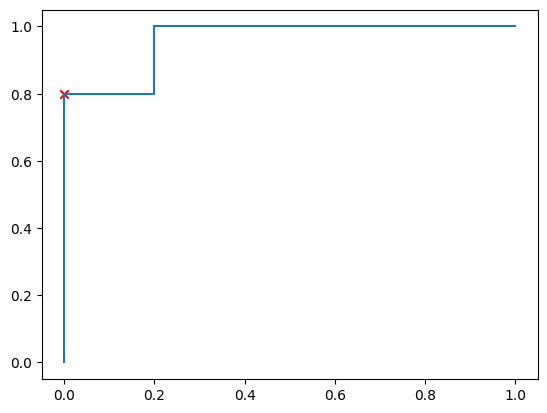

In [14]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

fpr, tpr, thresh = roc_curve(gt, tstats)
plt.plot(fpr, tpr)

best_thresh = thresh[(tpr - fpr).argmax()]
print(best_thresh)
plt.scatter([fpr[(tpr - fpr).argmax()]], [tpr[(tpr - fpr).argmax()]], marker='x', c='r')